# Aircraft Engine RUL Prediction

In [2]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler #to normalize data

import os
# os.chdir("C:/Data/aircraft/")

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras import callbacks

In [9]:
# based on data wrangling python notebook
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/train_FD004.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    
    print(df_train.head(10))

    df_test = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/test_FD004.txt', delim_whitespace=True, names=input_file_column_names)
    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/RUL_FD004.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    
    return df_train, df_test, y_true

In [10]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape
print(df_train.head(10))
np.savetxt('D:/timetofailure/datasample.txt',df_train.head(10), delimiter=',')

   UnitNumber  Cycle   OpSet1  OpSet2  OpSet3  SensorMeasure1  SensorMeasure2  \
0           1      1  42.0049  0.8400   100.0          445.00          549.68   
1           1      2  20.0020  0.7002   100.0          491.19          606.07   
2           1      3  42.0038  0.8409   100.0          445.00          548.95   
3           1      4  42.0000  0.8400   100.0          445.00          548.70   
4           1      5  25.0063  0.6207    60.0          462.54          536.10   
5           1      6  34.9996  0.8400   100.0          449.44          554.77   
6           1      7   0.0019  0.0001   100.0          518.67          641.83   
7           1      8  41.9981  0.8400   100.0          445.00          549.05   
8           1      9  42.0016  0.8400   100.0          445.00          549.55   
9           1     10  25.0019  0.6217    60.0          462.54          536.35   

   SensorMeasure3  SensorMeasure4  SensorMeasure5  ...  SensorMeasure13  \
0         1343.43         1112.93

## Model

### Data Preprocessing

To make sure that variance of features remain in the same range, it is important to scale the features. If a feature's variance is order of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not desirable.

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.fit_transform(df_test[feats])


LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [6]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [7]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [8]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [9]:
sequence_length = 50
mask_value = 0


Let's prepare data using above functions.

In [10]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(49048, 50, 15)


In [11]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(49048,)

In [12]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

C:\Users\elpaem\AppData\Local\Temp\ipykernel_21748\3243649304.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)


(248, 50, 15)


In [13]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(248,)

### LSTM Model

In [14]:
nb_features = x_train.shape[2]
nb_out = 1

In [15]:
nb_features

15

In [16]:
history = History()

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           46400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 126,901
Trainable params: 126,901
Non-trai

In [17]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
1380/1380 [==============================] - 104s 67ms/step - loss: 8908.7158 - mse: 8908.7158 - val_loss: 5139.7837 - val_mse: 5139.7837
Epoch 2/100
1380/1380 [==============================] - 91s 66ms/step - loss: 6468.5117 - mse: 6468.5117 - val_loss: 5151.1611 - val_mse: 5151.1611
Epoch 3/100
1380/1380 [==============================] - 93s 67ms/step - loss: 5793.6831 - mse: 5793.6831 - val_loss: 2658.1826 - val_mse: 2658.1826
Epoch 4/100
1380/1380 [==============================] - 95s 69ms/step - loss: 3291.0330 - mse: 3291.0330 - val_loss: 1912.6459 - val_mse: 1912.6459
Epoch 5/100
1380/1380 [==============================] - 95s 69ms/step - loss: 2761.8716 - mse: 2761.8716 - val_loss: 1931.3976 - val_mse: 1931.3976
Epoch 6/100
1380/1380 [==============================] - 95s 69ms/step - loss: 2526.1423 - mse: 2526.1423 - val_loss: 2081.3391 - val_mse: 2081.3391
Epoch 7/100
1380/1380 [==============================] - 96s 70ms/step - loss: 2288.7625 - mse: 2288.7625

Let's plot the loss

In [18]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

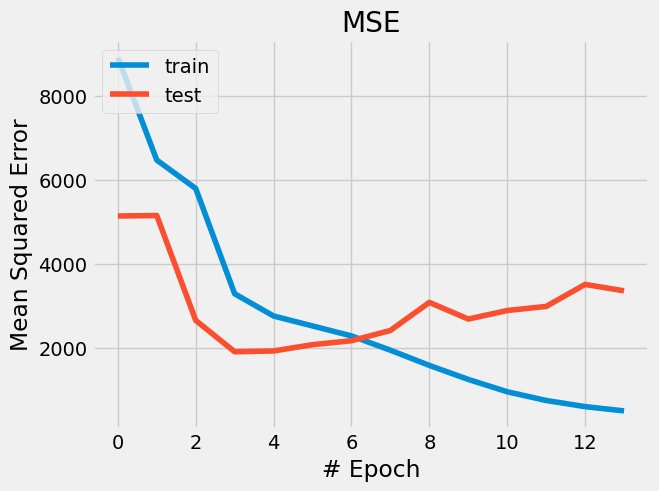

In [19]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Results on Train Set

In [20]:
scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

246/246 [==============================] - 19s 77ms/step - loss: 801.0292 - mse: 801.0292
MSE: 801.0291748046875


### Results on Test Set

In [21]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
print('MSE: {}'.format(scores_test[1]))

8/8 - 0s - loss: 2504.3672 - mse: 2504.3672 - 262ms/epoch - 33ms/step
MSE: 2504.3671875


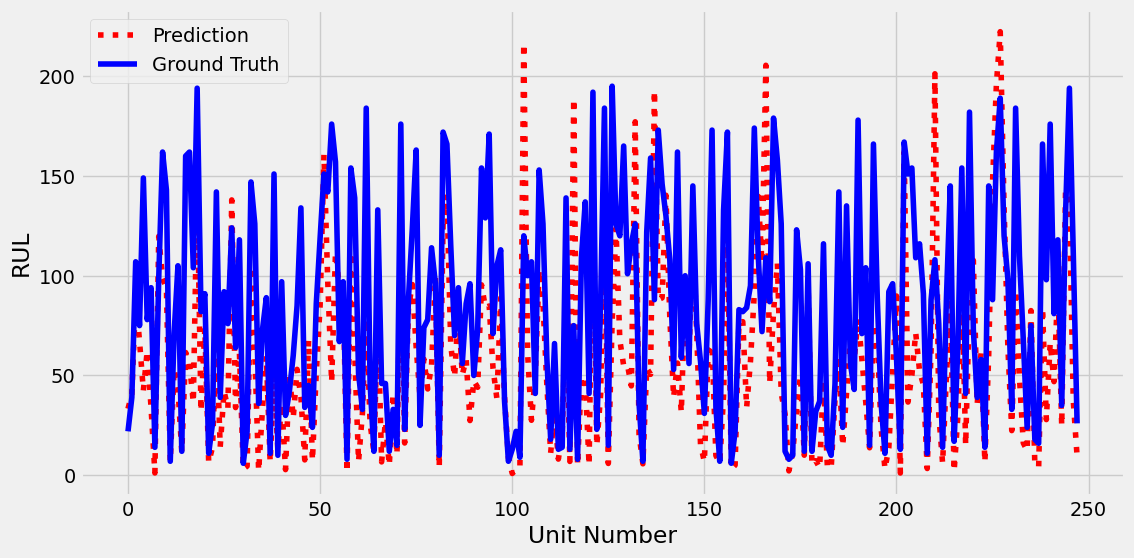

In [22]:
y_pred_test = model.predict(x_test, verbose=0)

np.savetxt('D:/timetofailure/pred.csv',y_pred_test, delimiter=',')
np.savetxt('D:/timetofailure/trueval.csv',y_test, delimiter=',')
plt.figure(figsize=(12,6))
plt.plot(y_pred_test, color='red', label='Prediction',  linestyle='dotted')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()